# Plot the Aggregated Fields using Bootstrap Error Bounds

This sheet is for oils  

Run on py39 to get thick lines for beaching

In [74]:
import cmocean.cm as cm
import copy
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

In [52]:
plt.rcParams.update({'font.size': 13})

In [2]:
thefile = '/data/sallen/MIDOSS/aggregated_spills_files/fiftieth_55_oils.nc'
oil = xr.open_dataset(thefile)
whichspills = "All Oil Spills"
smalloils = 113 + 54

In [3]:
mesh = xr.open_dataset('~/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]
divarea = 1/(mesh.e1t[0, 1:-1, 1:-1] * mesh.e2t[0, 1:-1, 1:-1])
alength = 1/np.maximum(mesh.e1t[0, 1:-1:, 1:-1], mesh.e2t[0, 1:-1, 1:-1])
mesh.close()

In [4]:
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
minColor = 0.1
maxColor = 0.85
thermal_r_t = truncate_colormap(cm.thermal_r, minColor, maxColor)

In [7]:
need = 4   # need four values at a point to calculate quartiles

## Beaching

### Beaching Presence: Set-up and Preparation

In [8]:
ma_beaching_pres = np.ma.masked_array(oil.beachpresence, oil.beachpresence == 0)

### Beaching Presence: Plot

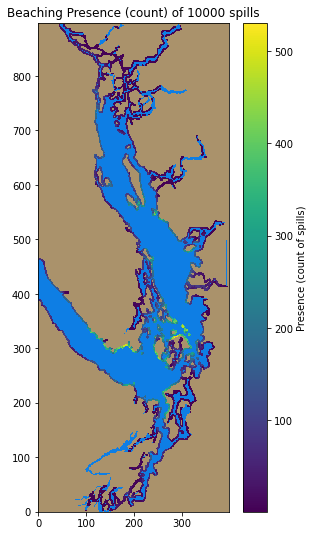

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)
ax.set_aspect(aspect)


C = ax.pcolormesh(
     ma_beaching_pres,
    zorder=2, #vmin=0, vmax=7
)
cb = fig.colorbar(C, ax=ax);    
cb.set_label('Presence (count of spills)')
ax.set_title(f'Beaching Presence (count) of {oil.nofiles.values+smalloils} spills');   

### Beaching Time: Set-up and Preparation

In [10]:
# Good if good to half a day or 25% of beaching time
absol = 0.5
perol = 0.25
eps = 1e-7
mcsize = 49

bt_absol = absol
bt_perol = perol

In [165]:
ma_beaching_time = np.ma.masked_array(oil.beaching_time[0]/(oil.beachpresence + eps), 
                                      oil.beachpresence == 0)

beachtime_25 = np.quantile(oil.beaching_time/(oil.beachpresence + eps), 0.25, axis=0)
beachtime_75 = np.quantile(oil.beaching_time/(oil.beachpresence + eps), 0.75, axis=0)

beached = np.ma.masked_array(oil.beaching_time[0]/(oil.beachpresence + eps), 
                             (oil.beachpresence < need) | (
    (beachtime_75 - beachtime_25 > absol) & 
            (beachtime_75 - beachtime_25 > perol*ma_beaching_time))) 

ma_beached_ste = np.ma.masked_array(beachtime_75 - beachtime_25, 
                                    oil.beachpresence < need)

print (ma_beaching_time.max())

6.958332637500069


### Beaching Time: Plot

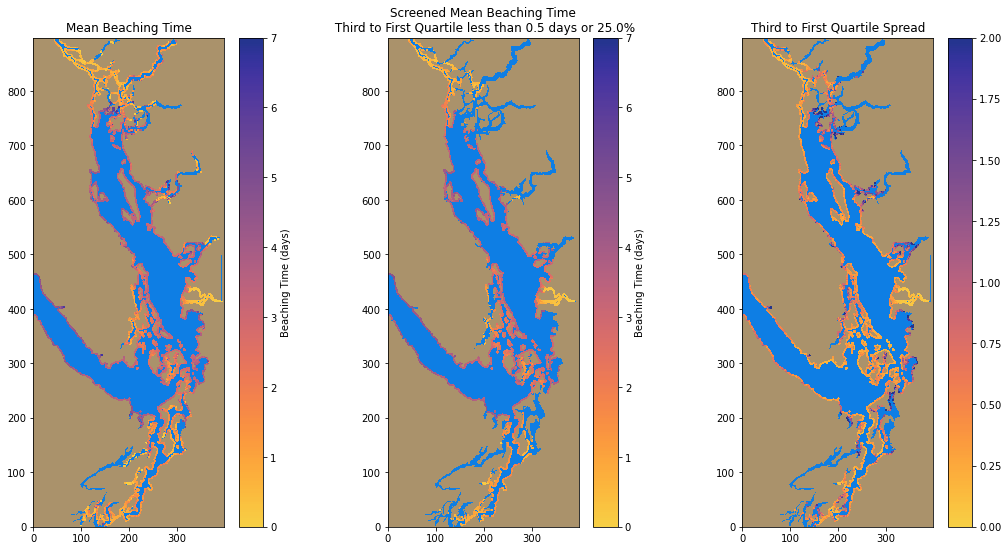

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)


C = axs[0].pcolormesh(
     ma_beaching_time,
    zorder=2, vmin=0, vmax=7, cmap=thermal_r_t
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Beaching Time (days)')
axs[0].set_title('Mean Beaching Time')
    
C = axs[1].pcolormesh(
     beached,
    zorder=2, vmin=0, vmax=7, cmap=thermal_r_t
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beaching Time (days)')
axs[1].set_title(
    f'Screened Mean Beaching Time\n Third to First Quartile less than {bt_absol} days or {bt_perol*100}%')

C = axs[2].pcolormesh(
     ma_beached_ste,
    zorder=2, vmin=0, vmax=2, cmap=thermal_r_t
)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Third to First Quartile Spread');

### Beaching Volume: Set-up and Preparation

In [13]:
# Good if good to 100% of beaching volume
# constants not used

In [168]:
ma_beach_oil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), 
                                  oil.beachpresence == 0)

beachoil_25 = np.quantile(oil.beaching_oil/(oil.beachpresence + eps), 0.25, axis=0)
beachoil_75 = np.quantile(oil.beaching_oil/(oil.beachpresence + eps), 0.75, axis=0)
beachedoil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), 
                                (oil.beachpresence < need) | (
    (np.exp(beachoil_75)-np.exp(beachoil_25) > np.exp(ma_beach_oil) )) )

ma_beachoil_ste = np.ma.masked_array(np.exp(beachoil_75)-np.exp(beachoil_25), 
                                     oil.beachpresence < need)
print (ma_beach_oil.max(), beachoil_75.max())

5.703288209696545 11.40657641939309


<xarray.DataArray ()>
array(0.02436321)
Coordinates:
    grid_x   int64 310
    grid_y   int64 315
    grid_z   int16 39
-2.4357083100905967
inter quartile 0.23996524611395875 0.5
<xarray.DataArray 'beachpresence' ()>
array(405.)
Coordinates:
    grid_x   int64 310
    grid_y   int64 315
    grid_z   int16 ...
0.021296168998290885
* -2.4357083100905967
2.351500185834489
0.017436078829357216


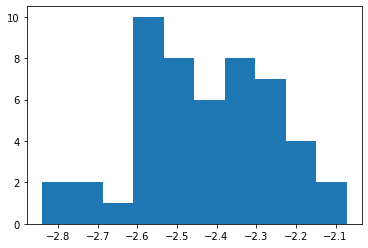

In [15]:
plt.hist(oil.beaching_oil[:, 315, 310]/(oil.beachpresence[315, 310] + eps))
print (np.std(oil.beaching_oil[:, 315, 310]/(oil.beachpresence[315, 310] + eps), axis=0, ddof=1) 
       / np.sqrt(mcsize))
print (ma_beach_oil[315, 310])
print ('inter quartile', beachoil_75[315, 310]-beachoil_25[315, 310], absol)
print (oil.beachpresence[315, 310])
print (ma_beachoil_ste[315, 310])
print ('*', beachedoil[315, 310])
print (np.exp(beachedoil.max()))
print (np.exp(beachedoil.min()))

In [16]:
print (divarea[200, 200], 500*440)
print (alength[200, 200])

<xarray.DataArray ()>
array(4.46502456e-06) 220000
<xarray.DataArray 'e1t' ()>
array(0.00197975)


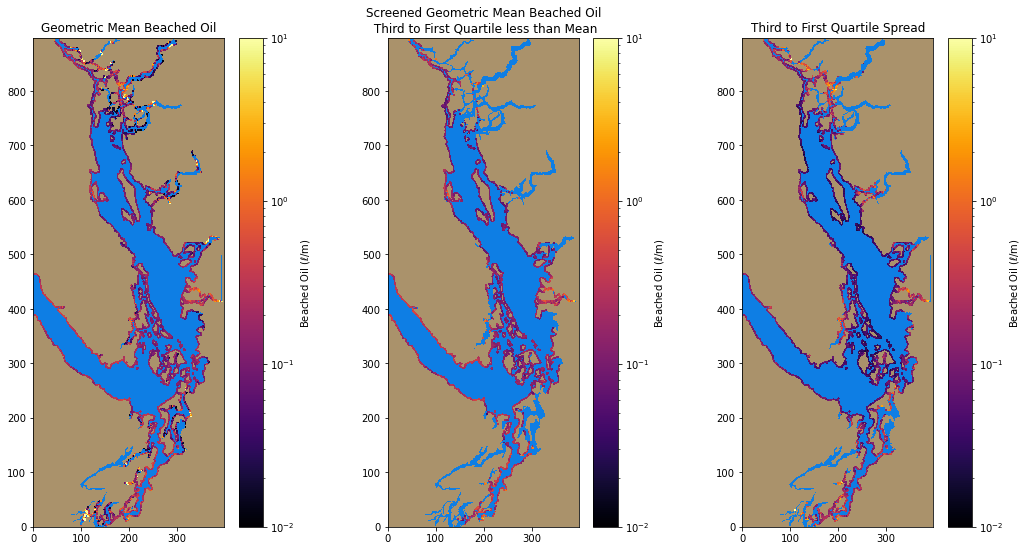

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

vmin, vmax = 0.01, 10

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)

C = axs[0].pcolormesh(
     np.exp(ma_beach_oil) * alength * 1000, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Beached Oil ($\ell$/m)')
axs[0].set_title('Geometric Mean Beached Oil')
    
C = axs[1].pcolormesh(
     np.exp(beachedoil) * alength * 1000,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[1].set_title(
   f'Screened Geometric Mean Beached Oil\n Third to First Quartile less than Mean')

C = axs[2].pcolormesh(
     ma_beachoil_ste * alength * 1000, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[2].set_title('Third to First Quartile Spread');


## Surface Oil

### Surface Oil Presence: Set-up and Prep

In [18]:
ma_oil_pres = np.ma.masked_array(oil.oilpresence, oil.oilpresence == 0)

### Surface Oil Presence: Plot

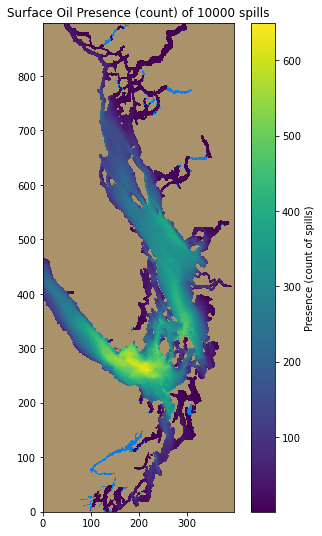

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)
ax.set_aspect(aspect)


C = ax.pcolormesh(ma_oil_pres, zorder=2,)# cmap='gist_ncar')
cb = fig.colorbar(C, ax=ax);    
cb.set_label('Presence (count of spills)')
ax.set_title(f'Surface Oil Presence (count) of {oil.nofiles.values+smalloils} spills');   

### Oil Arrival Time: Set-up and Preparation

In [20]:
# Good if good to half a day or 25% of arrival time
absol = 0.5
perol = 0.25

at_absol = absol
at_perol = perol

In [169]:
ma_arrival_time = np.ma.masked_array(oil.oiling_time[0]/(oil.oilpresence + eps), 
                                     oil.oilpresence == 0)

arrival_25 = np.quantile(oil.oiling_time/(oil.oilpresence + eps), 0.25, axis=0)
arrival_75 = np.quantile(oil.oiling_time/(oil.oilpresence + eps), 0.75, axis=0)


arrived = np.ma.masked_array(oil.oiling_time[0]/(oil.oilpresence + eps), 
                             (oil.oilpresence < need) | (
    (arrival_75 - arrival_25 > absol) 
    & (arrival_75 - arrival_25 > perol*ma_arrival_time))) 

ma_arrived_ste = np.ma.masked_array(arrival_75 - arrival_25, 
                                    oil.oilpresence < need)

print (ma_arrival_time.max())

6.99999930000007


### Oil Arrival: Plot

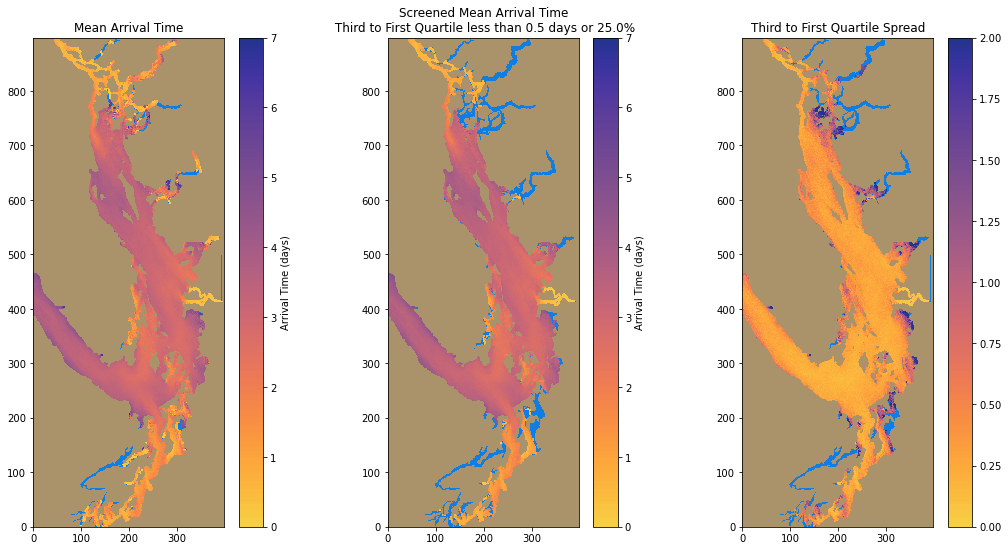

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)


C = axs[0].pcolormesh(ma_arrival_time, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Arrival Time (days)')
axs[0].set_title('Mean Arrival Time')
    
C = axs[1].pcolormesh(arrived, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Arrival Time (days)')
axs[1].set_title(f'Screened Mean Arrival Time\n Third to First Quartile less than {at_absol} days or {at_perol*100}%')

C = axs[2].pcolormesh(ma_arrived_ste, zorder=2, vmin=0, vmax=2, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Third to First Quartile Spread');


### Surface Oil Volume: Set-up and Preparation

In [23]:
# Good if good to 100% of surface volume
# constants not used

In [171]:
ma_surface_oil = np.ma.masked_array(oil.surface_oil[0]/(oil.oilpresence + eps), 
                                    oil.oilpresence == 0)

surfoil_25 = np.quantile(oil.surface_oil/(oil.oilpresence + eps), 0.25, axis=0)
surfoil_75 = np.quantile(oil.surface_oil/(oil.oilpresence + eps), 0.75, axis=0)

surfoiled = np.ma.masked_array(oil.surface_oil[0]/(oil.oilpresence + eps), 
                               (oil.oilpresence < need) | (
    (np.exp(surfoil_75) - np.exp(surfoil_25) > np.exp(ma_surface_oil)) )) 

ma_surfoil_del = np.ma.masked_array(np.exp(surfoil_75) - 
                                    np.exp(surfoil_25), oil.oilpresence < need)

print (ma_surface_oil.max(), surfoil_75.max())

7.129695074040375 14.055608038963308


-2.4059573249851707
-2.5094133268194367 -2.281914583505342
del 0.02077263128325449 0.5
<xarray.DataArray 'oilpresence' ()>
array(279.)
Coordinates:
    grid_x   int64 300
    grid_y   int64 400
    grid_z   int16 ...
* -2.4059573249851707
3.938589436774221
0.014136484929468304
****
0.09017912354520241
0.0813159311256929 0.10208856240894738
0.02077263128325449


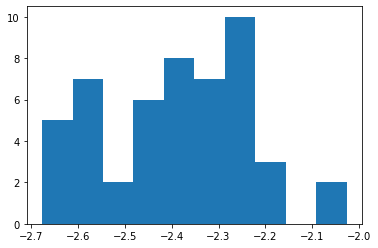

In [25]:
plt.hist(oil.surface_oil[:, 400, 300]/(oil.oilpresence[400, 300] + eps))

print (ma_surface_oil[400, 300])
print (surfoil_25[400, 300], surfoil_75[400, 300])

print ('del', ma_surfoil_del[400, 300], absol)
print (oil.oilpresence[400, 300])
print ('*', surfoiled[400, 300])
print (np.exp(surfoiled.max()))
print (np.exp(surfoiled.min()))

print ('****')
print (np.exp(ma_surface_oil[400, 300]))
print (np.exp(surfoil_25[400, 300]), np.exp(surfoil_75[400, 300]))
print (np.exp(surfoil_75[400, 300]) - np.exp(surfoil_25[400, 300]))

### Surface Oil: Plots

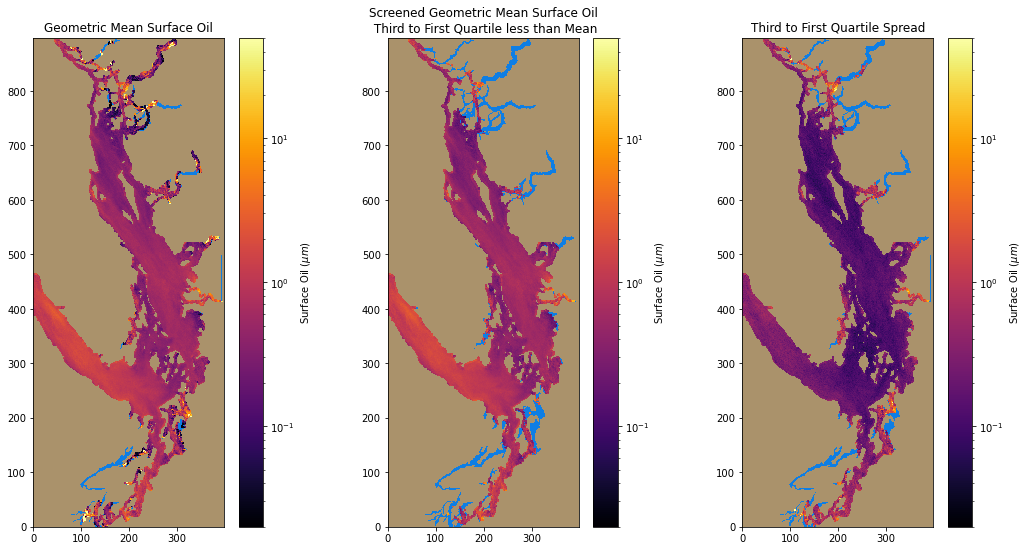

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

vmin, vmax = 0.02, 50

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)


C = axs[0].pcolormesh(
     np.exp(ma_surface_oil) * divarea * 1e6, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Surface Oil ($\mu m$)')
axs[0].set_title('Geometric Mean Surface Oil')
    
C = axs[1].pcolormesh(
     np.exp(surfoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Surface Oil ($\mu m$)')
axs[1].set_title(
    f'Screened Geometric Mean Surface Oil\n Third to First Quartile less than Mean')

C = axs[2].pcolormesh(
     ma_surfoil_del * divarea * 1e6, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('Surface Oil ($\mu m$)')
axs[2].set_title('Third to First Quartile Spread');

## Watercolumn Oil

### Watercolumn Presence: Set-up and Preparation

In [27]:
ma_deep_pres = np.ma.masked_array(oil.deeppresence, oil.deeppresence == 0)

### Watercolumn Presence: Plot

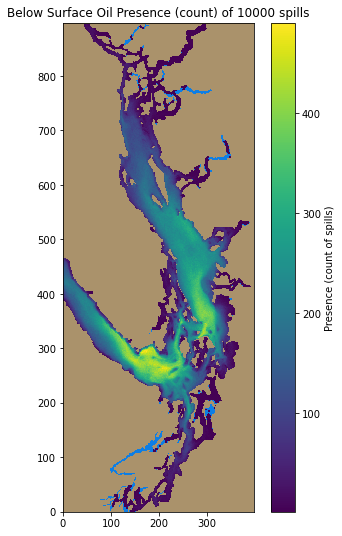

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))

ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
ax.set_ylim(imin, imax)
ax.set_xlim(jmin, jmax)
ax.set_aspect(aspect)


C = ax.pcolormesh(ma_deep_pres, zorder=2)
cb = fig.colorbar(C, ax=ax);    
cb.set_label('Presence (count of spills)')
ax.set_title(f'Below Surface Oil Presence (count) of {oil.nofiles.values+smalloils} spills');   

### Watercolumn Depth: Set-up and Preparation

In [172]:
# Good if good to 5 m or 25% of depth
absol = 5
perol = 0.25

wd_absol = absol
wd_perol = perol

In [174]:
ma_deep_location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), 
                                      oil.deeppresence == 0)
print (oil.deep_location.shape)
location_25 = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.25, axis=0)
location_75 = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.75, axis=0)
print (location_25.shape)

location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), 
                              (oil.deeppresence < need) | (
    (location_75 - location_25 > absol) 
    & (location_75 - location_25 > perol*ma_deep_location))) 

ma_location_del = np.ma.masked_array(location_75 - location_25, oil.deeppresence < need)

print (ma_deep_location.max())

(50, 896, 396)
(896, 396)
279.9262886394291


55.88931975981047 <xarray.DataArray 'deeppresence' ()>
array(378.)
Coordinates:
    grid_x   int64 300
    grid_y   int64 350
    grid_z   int16 ...


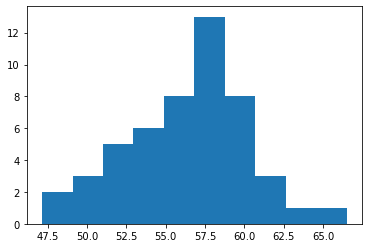

In [175]:
plt.hist(oil.deep_location[:, 350, 300]/oil.deeppresence[350, 300]);
print (ma_deep_location[350, 300], oil.deeppresence[350, 300])

### Watercolumn Depth: Plot

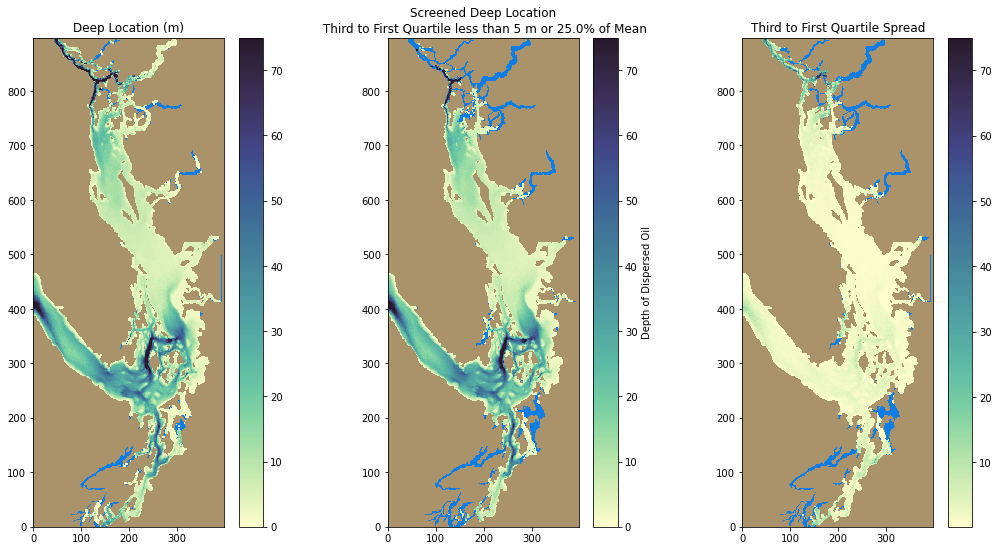

In [176]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)

C = axs[0].pcolormesh(
     ma_deep_location,
    zorder=2, vmin=0, vmax=75, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[0]);    
axs[0].set_title('Deep Location (m)');    

C = axs[1].pcolormesh(
     location,
    zorder=2, vmin=0, vmax=75, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Depth of Dispersed Oil')
axs[1].set_title(
    f'Screened Deep Location\n Third to First Quartile less than {wd_absol} m or {wd_perol*100}% of Mean')

C = axs[2].pcolormesh(ma_location_del, 
    zorder=2, vmax=75, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[2]);
axs[2].set_title('Third to First Quartile Spread');

### Watercolumn Volume: Set-up and Preparation

In [33]:
# Good if good to 100% of volume
# constants not needed

In [177]:
ma_deep_oil = np.ma.masked_array(oil.deep_oil[0]/(oil.deeppresence + eps), 
                                 oil.deeppresence == 0)

deepoil_25 = np.quantile(oil.deep_oil/(oil.deeppresence + eps), 0.25, axis=0)
deepoil_75 = np.quantile(oil.deep_oil/(oil.deeppresence + eps), 0.75, axis=0)

deepoiled = np.ma.masked_array(oil.deep_oil[0]/(oil.deeppresence + eps), 
                               (oil.deeppresence < need) | (
    (np.exp(deepoil_75) - np.exp(deepoil_25) > np.exp(ma_deep_oil)) )) 

ma_deepoil_ste = np.ma.masked_array(np.exp(deepoil_75) 
                                    - np.exp(deepoil_25), oil.deeppresence < need)

### Watercolumn Volume: Plots

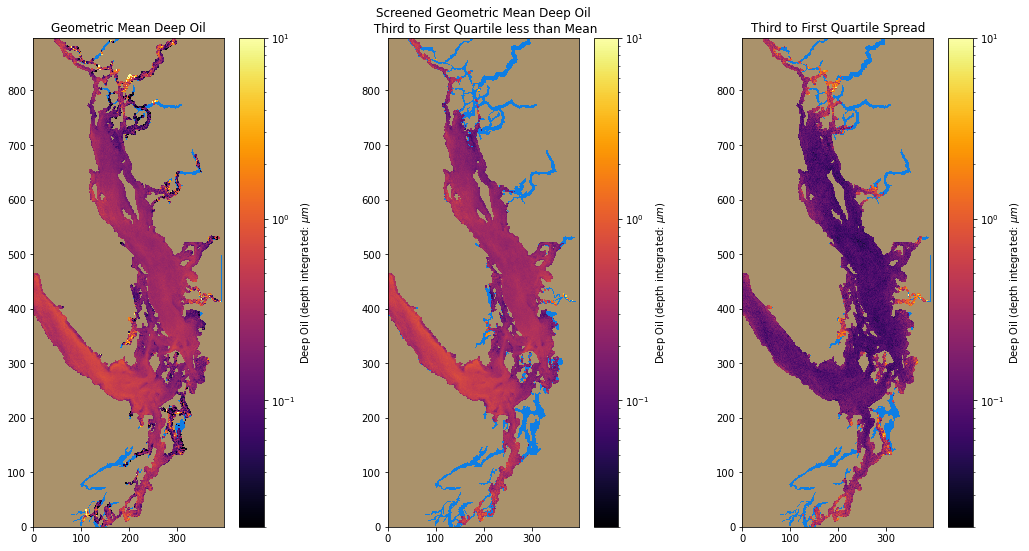

In [178]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

vmin, vmax = 0.02, 10

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)


C = axs[0].pcolormesh(
     np.exp(ma_deep_oil) * divarea * 1e6, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[0].set_title('Geometric Mean Deep Oil')
    
C = axs[1].pcolormesh(
     np.exp(deepoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[1].set_title(
    f'Screened Geometric Mean Deep Oil\n Third to First Quartile less than Mean')

C = axs[2].pcolormesh(
     ma_deepoil_ste
     * divarea * 1e6, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[2].set_title('Third to First Quartile Spread');

## Screened Plots

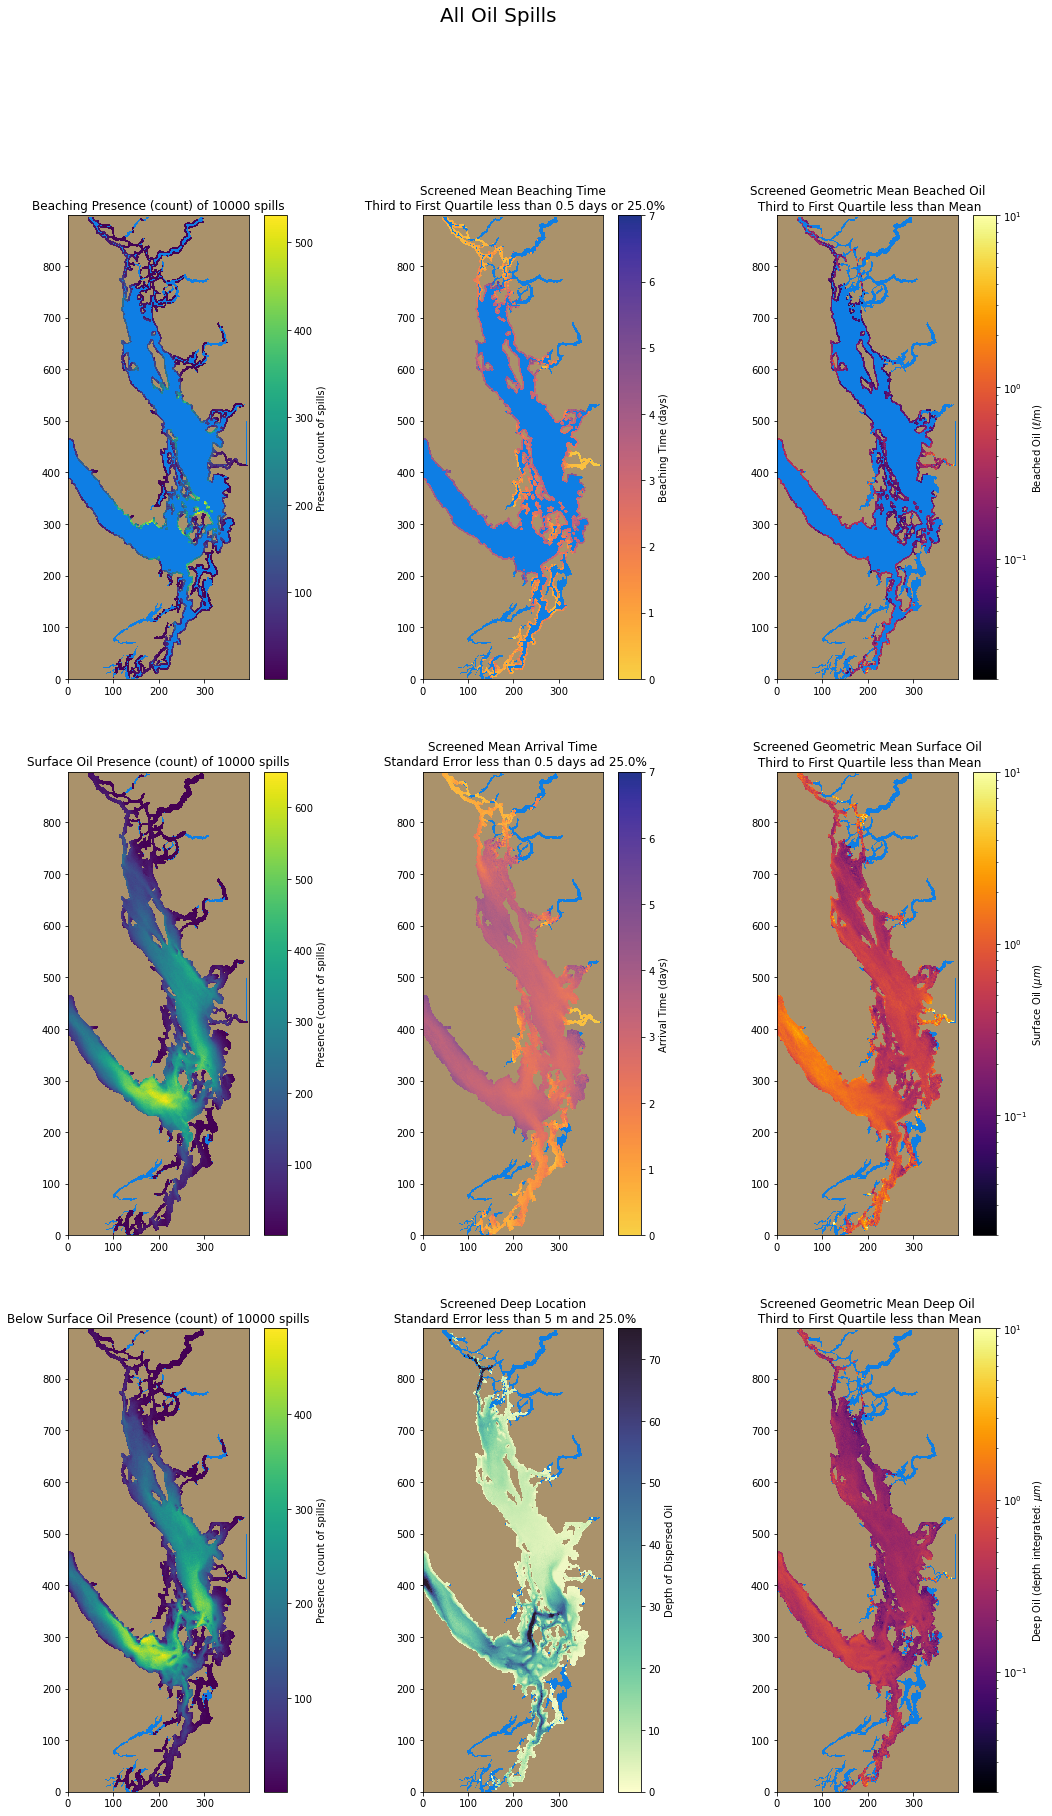

In [179]:
fig, axs = plt.subplots(3, 3, figsize=(18, 9*3+2))

fig.suptitle(f'{whichspills}', fontsize=20)
vmax = 10
vmin = 0.02

for i in range(3):
    for ax in axs[i]:
        ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
        ax.set_ylim(imin, imax)
        ax.set_xlim(jmin, jmax)
        ax.set_aspect(aspect)

        
C = axs[0, 0].pcolormesh(ma_beaching_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[0, 0]);    
cb.set_label('Presence (count of spills)')
axs[0, 0].set_title(
    f'Beaching Presence (count) of {oil.nofiles.values+smalloils} spills');   

C = axs[0, 1].pcolormesh(beached, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[0, 1]);
cb.set_label('Beaching Time (days)')
axs[0, 1].set_title(
    f'Screened Mean Beaching Time\n Third to First Quartile less than {bt_absol} days or {bt_perol*100}%');

C = axs[0, 2].pcolormesh(np.exp(beachedoil) * alength * 1000, zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')
cb = fig.colorbar(C, ax=axs[0, 2]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[0, 2].set_title(
    f'Screened Geometric Mean Beached Oil\n Third to First Quartile less than Mean');

C = axs[1, 0].pcolormesh(ma_oil_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[1, 0]);    
cb.set_label('Presence (count of spills)')
axs[1, 0].set_title(
    f'Surface Oil Presence (count) of {oil.nofiles.values+smalloils} spills');  

C = axs[1, 1].pcolormesh(arrived, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[1, 1]);
cb.set_label('Arrival Time (days)')
axs[1, 1].set_title(
    f'Screened Mean Arrival Time\n Standard Error less than {at_absol} days ad {at_perol*100}%');

C = axs[1, 2].pcolormesh(
     np.exp(surfoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')
cb = fig.colorbar(C, ax=axs[1, 2]);
cb.set_label('Surface Oil ($\mu m$)')
axs[1, 2].set_title(
    f'Screened Geometric Mean Surface Oil\n Third to First Quartile less than Mean');


C = axs[2, 0].pcolormesh(ma_deep_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[2, 0]);    
cb.set_label('Presence (count of spills)')
axs[2, 0].set_title(
    f'Below Surface Oil Presence (count) of {oil.nofiles.values+smalloils} spills');   

C = axs[2, 1].pcolormesh(
     location,
    zorder=2, vmin=0, vmax=75, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[2, 1]);
cb.set_label('Depth of Dispersed Oil')
axs[2, 1].set_title(
    f'Screened Deep Location\n Standard Error less than {wd_absol} m and {wd_perol*100}%');

C = axs[2, 2].pcolormesh(
     np.exp(deepoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2, 2]);
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[2, 2].set_title(
    f'Screened Geometric Mean Deep Oil\n Third to First Quartile less than Mean');


In [84]:
location.shape, ma_deep_pres.shape

((896, 396), (896, 396))

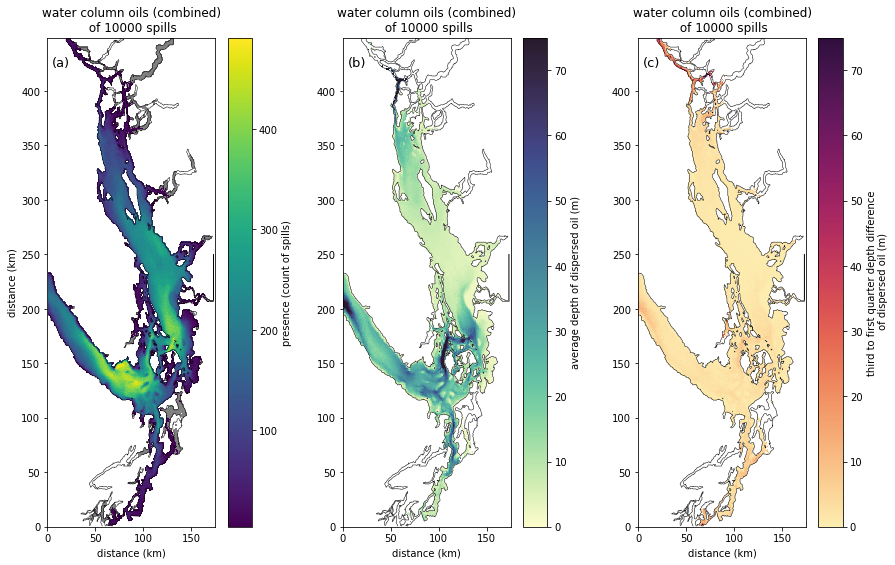

In [196]:
mylabels = ['(a)', '(b)', '(c)']

fig, axs = plt.subplots(1, 3, figsize=(15, 9))

minnum_spills = 4

for iax, ax in enumerate(axs):
    ax.contour(np.arange(jmin+1, jmax)*0.440, np.arange(imin+1, imax)*0.500, tmask[1:, 1:], 
              levels=[0.5], colors=['k'], linewidths=[0.5], zorder=5)
    ax.set_ylim(imin*0.500, imax*0.500)
    ax.set_xlim(jmin*0.44, jmax*0.44)
    ax.set_aspect(aspect)
    ax.set_xlabel('distance (km)')
    ax.text(5, 420, mylabels[iax],
            fontsize=13, verticalalignment='bottom',
            )
    ax.set_title(
    f'water column oils (combined)\n of {oil.nofiles.values+smalloils} spills');
axs[0].set_ylabel('distance (km)')


cmap = copy.copy(plt.get_cmap('viridis'))
cmap.set_under('grey')
C = axs[0].pcolormesh(np.arange(jmin+1, jmax)*0.440, np.arange(imin+1, imax)*0.500, ma_deep_pres, zorder=2,
                     vmin=minnum_spills, cmap=cmap)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')

filter_location = copy.copy(location)
filter_location[ma_deep_pres < minnum_spills] = -1

cmap = copy.copy(cm.deep)
cmap.set_under('w')
C = axs[1].pcolormesh(np.arange(jmin+1, jmax)*0.440, np.arange(imin+1, imax)*0.500,
     filter_location,
    zorder=2, vmin=0, vmax=75, cmap=cmap
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('average depth of dispersed oil (m)')


filter_del = copy.copy(ma_location_del)
filter_del[ma_deep_pres < minnum_spills] = -1

cmap = copy.copy(cm.matter)
cmap.set_under('w')

C = axs[2].pcolormesh(np.arange(jmin+1, jmax)*0.440, np.arange(imin+1, imax)*0.500, filter_del, 
    zorder=2, vmax=75, cmap=cmap, vmin=0
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('third to first quarter depth difference\n of dispersed oil (m)')
fig.savefig('Waterdepth_figure.pdf');

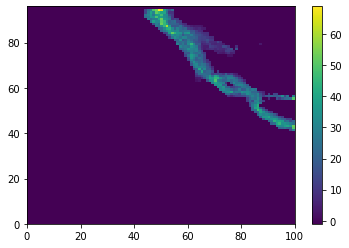

In [181]:
plt.pcolormesh(filter_del[800:, 0:100])
plt.colorbar();

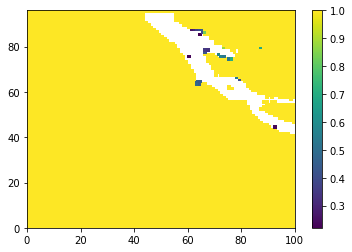

In [182]:
plt.pcolormesh(filter_del[800:, 0:100]/filter_location[800:, 0:100])
plt.colorbar();

In [194]:
ma_deep_location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), 
                                      oil.deeppresence == 0)
print (oil.deep_location.shape)
location_25 = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.25, axis=0)
location_75 = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.75, axis=0)
print (location_25.shape)

location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), 
                              (oil.deeppresence < need) | (
    (location_75 - location_25 > absol) 
    & (location_75 - location_25 > perol*ma_deep_location))) 

ma_location_del = np.ma.masked_array(location_75 - location_25, oil.deeppresence < need)

(50, 896, 396)
(896, 396)


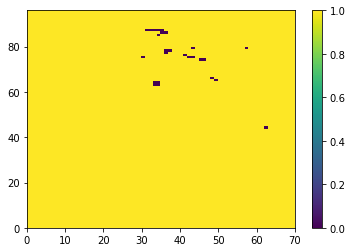

In [195]:
plt.pcolormesh(location[800:, 30:100].mask)
plt.colorbar();

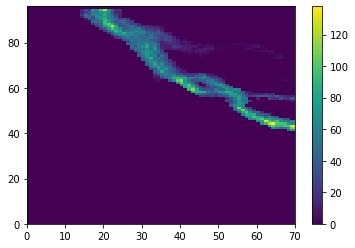

In [186]:
plt.pcolormesh(location_25[800:, 30:100])
plt.colorbar();

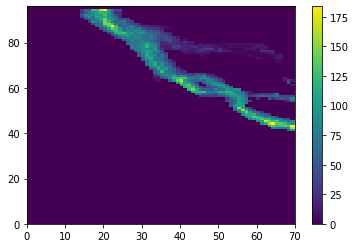

In [187]:
plt.pcolormesh(location_75[800:, 30:100])
plt.colorbar();

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f5b95bd3a60> (for post_execute):


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

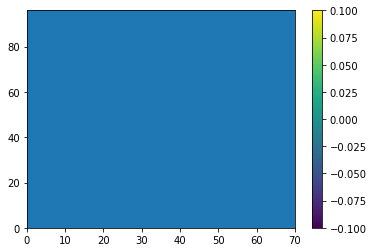

In [193]:
zmask = (oil.deeppresence < need) | (
    (location_75 - location_25 > absol) 
    & (location_75 - location_25 > perol*ma_deep_location))
plt.pcolormesh(zmask[800:, 30:100])
plt.colorbar();